### Experimenting with GBS

In [80]:
import strawberryfields as sf
from strawberryfields import ops
import numpy as np
from matplotlib import pyplot as plt
import thewalrus as walrus
import networkx as nx
import itertools

#### Verifying that GBS Actually Works

We can begin by defining an apparatus described by squeezing gates and interferometers 

[[0. +0.j 0.1+0.j 0.1+0.j 0.1+0.j]
 [0.1+0.j 0. +0.j 0.1+0.j 0. +0.j]
 [0.1+0.j 0.1+0.j 0. +0.j 0.1+0.j]
 [0.1+0.j 0. +0.j 0.1+0.j 0. +0.j]]


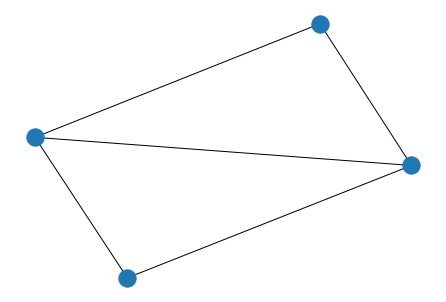

In [81]:
# Define some arbitrary matrix which we will use in our GBS experiment

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (0, 2)])
nx.draw(G)

matrix = 0.1*np.array(nx.to_numpy_matrix(G), dtype=np.complex)

print(matrix)

In [82]:
# Method that calculates the submatrix corresponding to a given sample

def reduce_matrix(matrix, string):
    
    matrix = np.repeat(matrix, repeats=string, axis=0)
    return np.repeat(matrix, repeats=string, axis=1)

# Performs the Takagi decomposition of the matrix

takagi = sf.decompositions.takagi(matrix)
print(takagi)

# Calculates the normalization factor

prod = 1
for i in takagi[0]:
    prod *= 1 - i**2

(array([2.56155281e-01, 1.56155281e-01, 1.00000000e-01, 5.20417043e-18]), array([[ 5.57345410e-01+0.00000000e+00j,  0.00000000e+00-4.35162146e-01j,
         0.00000000e+00-7.07106781e-01j, -2.25959390e-16+0.00000000e+00j],
       [ 4.35162146e-01+0.00000000e+00j,  0.00000000e+00+5.57345410e-01j,
         0.00000000e+00+2.22044605e-16j,  7.07106781e-01+0.00000000e+00j],
       [ 5.57345410e-01+0.00000000e+00j,  0.00000000e+00-4.35162146e-01j,
         0.00000000e+00+7.07106781e-01j,  1.11022302e-16+0.00000000e+00j],
       [ 4.35162146e-01+0.00000000e+00j,  0.00000000e+00+5.57345410e-01j,
         0.00000000e+00+5.55111512e-16j, -7.07106781e-01+0.00000000e+00j]]))


In [83]:
def calculate_prob(matrix, string):
    
    # Calculates the reduced matrix
    r_matrix = reduce_matrix(matrix, string)
    
    # Calculates the normalization factor
    norm = 1
    for i in string:
        norm *= np.math.factorial(i)
    
    # Calculates the final probability
    final_val = np.sqrt(prod)*(abs(walrus.hafnian(r_matrix))**2) / norm
    
    return final_val

In [84]:
cutoff = 5
modes = 4

def gbs_array(squeezing_params, unitary, modes):
    
    prog = sf.Program(modes)
    
    with prog.context as q:
        
        for i in range(0, modes):
            ops.Sgate(squeezing_params[i]) | q[i]
        
        ops.Interferometer(unitary) | q
        
    result = eng.run(prog)
    
    return result.state

In [85]:
# Finds the probability of measuring some state, and compares it to the theoretical value

sample_val = [0, 0, 0, 0]
eng = sf.Engine("fock", backend_options={"cutoff_dim": 10})

# Calculates the theoretical value

theoretical = calculate_prob(matrix, sample_val)
print("Theoretical Value: {}".format(theoretical))

# Calculates the experimental value

squeezing = [np.arctanh(i) for i in takagi[0]]
state = gbs_array(squeezing, takagi[1], modes)
print("Experimental Value: {}".format(state.fock_prob(sample_val)))

Theoretical Value: 0.9499915789100449
Experimental Value: 0.949991578910045
